### Goal

Test new ideas of implementing metrics

### TODO
- Imagine genes as a time series - compute the fourier transform and apply pearson corr.

In [1]:
# code autoreload
%load_ext autoreload
%autoreload 2
import os

import random
import math
import numpy.random as nr
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as scistats

import scanpy.api as sc
import anndata as ad
import xarray as xr
import dask.array as da

## init plotly
# from plotly.offline import iplot, init_notebook_mode
# init_notebook_mode(connected=True)
import plotly.io as pio
pio.renderers.default = 'iframe_connected'
import plotly.graph_objs as go

import sklearn



/opt/modules/i12g/anaconda/3-2018.12/envs/florian/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/opt/modules/i12g/anaconda/3-2018.12/envs/florian/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [2]:
CACHE_DIR="/s/project/rep/cache/"
RAW_DATA_DIR="/s/project/rep/raw/"
PROCESSED_DATA_DIR="/s/project/rep/processed/"

In [3]:
import joblib

memory = joblib.Memory(CACHE_DIR)

@memory.cache
def preproc(infile):
    adata = ad.read_h5ad(infile)
    
    # apply size factors
    adata.X = adata.X / adata.obs["sf"][:, None]
    
    # select 15,000 most highly expressed genes
    adata = adata[:, np.argsort(adata.var["feature_mean"])[-15000:]]
    
    return(adata)


In [4]:
raw_data = preproc(os.path.join(PROCESSED_DATA_DIR, "gtex/gagneurlab/raw_counts.h5ad"))
raw_data

View of AnnData object with n_obs × n_vars = 6766 × 15000 
    obs: 'RNA.Seq', 'SRA_Sample', 'sex', 'BioSample', 'Experiment', 'tissue', 'subtissue', 'RIN', 'SMAFRZE', 'WGS', 'WXS', 'OUTRIDER_GROUP', 'COUNT_MODE', 'PAIRED_END', 'COUNT_OVERLAP', 'CHROMOSOME_STYLE', 'STRAND', 'sf', 'individual'
    var: 'gene_name', 'gene_name_orig', 'gene_type', 'feature_mean'

In [5]:
xrds = xr.DataArray(
    np.log(raw_data.X + 1),
    dims=("observations", "features"),
    coords={
        "observations": xr.DataArray(raw_data.obs_names, dims=("observations", )),
        "features": xr.DataArray(raw_data.var_names, dims=("features", )),
        **raw_data.obs.to_xarray().rename_dims({"index":"observations"}),
        **raw_data.var.to_xarray().rename_dims({"index":"features"})
    }
)
xrds.chunk({"observations": 1000, "features": 1000})

<xarray.DataArray (observations: 6766, features: 15000)>
dask.array<shape=(6766, 15000), dtype=float64, chunksize=(1000, 1000)>
Coordinates:
  * observations      (observations) object 'GTEX-111CU-1826-SM-5GZYN' ... 'GTEX-ZXG5-0005-SM-57WCN'
  * features          (features) object 'ENSG00000243667.6_3' ... 'ENSG00000198804.2'
    RNA.Seq           (observations) object dask.array<shape=(6766,), chunksize=(1000,)>
    SRA_Sample        (observations) object dask.array<shape=(6766,), chunksize=(1000,)>
    sex               (observations) object dask.array<shape=(6766,), chunksize=(1000,)>
    BioSample         (observations) object dask.array<shape=(6766,), chunksize=(1000,)>
    Experiment        (observations) object dask.array<shape=(6766,), chunksize=(1000,)>
    tissue            (observations) object dask.array<shape=(6766,), chunksize=(1000,)>
    subtissue         (observations) object dask.array<shape=(6766,), chunksize=(1000,)>
    RIN               (observations) float64 dask

In [6]:
means = xrds.groupby("subtissue").mean(dim="observations")
xrds = xrds - means.sel(subtissue=xrds.subtissue)
del means

xrds

<xarray.DataArray (observations: 6766, features: 15000)>
array([[ 0.072478,  1.246804,  0.006964, ..., -1.410541, -0.426755, -0.662682],
       [ 0.179574,  0.168402,  0.267652, ..., -1.028726, -0.253286, -0.073146],
       [ 0.22249 ,  0.994314,  0.505779, ...,  0.226752, -0.464972,  0.015349],
       ...,
       [-0.251827,  1.477923, -0.872764, ..., -1.268596,  0.482969,  0.358743],
       [-0.097678, -0.442857,  0.763224, ...,  0.735658,  1.016051,  1.040805],
       [-0.429638, -0.442857,  0.270806, ..., -0.789645,  0.064284,  0.171533]])
Coordinates:
  * observations      (observations) object 'GTEX-111CU-1826-SM-5GZYN' ... 'GTEX-ZXG5-0005-SM-57WCN'
  * features          (features) object 'ENSG00000243667.6_3' ... 'ENSG00000198804.2'
    RNA.Seq           (observations) object 'SRR1310275' ... 'SRR1382485'
    SRA_Sample        (observations) object 'SRS623944' ... 'SRS635146'
    sex               (observations) object 'male' 'male' ... 'female' 'male'
    BioSample         (obs

In [8]:
pca = sklearn.decomposition.PCA(n_components=100).fit_transform(xrds)
pca = xr.DataArray(
    pca,
    dims=("observations", "PCA"),
    coords={
        key: (vals.dims, vals.values) for key, vals in xrds.coords.items() if vals.dims == ("observations",)
    },
)
pca

<xarray.DataArray (observations: 6766, PCA: 100)>
array([[ -8.510453,  12.010473,  -9.855328, ...,  -1.488417,   3.468963,
          2.440657],
       [ 17.139617, -18.087432,  16.693146, ...,  -2.510312,  -0.7553  ,
          2.713755],
       [-17.413748, -20.632556, -21.437019, ...,   2.163811,  -0.418579,
         -2.236079],
       ...,
       [  2.622763,  36.09507 ,   1.615654, ...,   0.107968,   2.240156,
         -1.4996  ],
       [  0.449178, -36.720284,  -5.745751, ...,  -1.522479,  -0.609757,
          1.50103 ],
       [  7.606553,  -0.664109,   0.159593, ...,  -1.257009,   2.489501,
         -2.294106]])
Coordinates:
  * observations      (observations) object 'GTEX-111CU-1826-SM-5GZYN' ... 'GTEX-ZXG5-0005-SM-57WCN'
    RNA.Seq           (observations) object 'SRR1310275' ... 'SRR1382485'
    SRA_Sample        (observations) object 'SRS623944' ... 'SRS635146'
    sex               (observations) object 'male' 'male' ... 'female' 'male'
    BioSample         (observations

In [9]:
def calc_corrs(adata):
    xrds = xr.DataArray(
        adata.X,
        dims=("observations", "features"),
        coords={
            "observations": xr.DataArray(raw_data.obs_names, dims=("observations", )),
            "features": xr.DataArray(raw_data.var_names, dims=("features", )),
            **raw_data.obs.to_xarray().rename_dims({"index":"observations"}),
            **raw_data.var.to_xarray().rename_dims({"index":"features"})
        }
    )
    
    corrs = np.corrcoef(xrds)

    corrs_xr = xr.DataArray(
        corrs,
        dims=("observations_1", "observations_2"),
        coords={
            **{
                key + "_1": (("observations_1",), vals.values) for key, vals in xrds.coords.items() if vals.dims == ("observations",)
            },
            **{
                key + "_2": (("observations_2",), vals.values) for key, vals in xrds.coords.items() if vals.dims == ("observations",)
            },
        }
    )
    #corrs = corrs[corrs.subtissue_1.values[:, None] == corrs.subtissue_2.values]
    return corrs_xr

In [10]:
corrs = calc_corrs(np.log(raw_data + 1))
corrs

<xarray.DataArray (observations_1: 6766, observations_2: 6766)>
array([[ 1.      , -0.094487,  0.1363  , ...,  0.213144, -0.074972,  0.002367],
       [-0.094487,  1.      ,  0.032612, ..., -0.033683,  0.051665,  0.00478 ],
       [ 0.1363  ,  0.032612,  1.      , ...,  0.031478,  0.002538,  0.113026],
       ...,
       [ 0.213144, -0.033683,  0.031478, ...,  1.      , -0.528096, -0.046895],
       [-0.074972,  0.051665,  0.002538, ..., -0.528096,  1.      ,  0.039605],
       [ 0.002367,  0.00478 ,  0.113026, ..., -0.046895,  0.039605,  1.      ]])
Coordinates:
  * observations_1      (observations_1) object 'GTEX-111CU-1826-SM-5GZYN' ... 'GTEX-ZXG5-0005-SM-57WCN'
    RNA.Seq_1           (observations_1) object 'SRR1310275' ... 'SRR1382485'
    SRA_Sample_1        (observations_1) object 'SRS623944' ... 'SRS635146'
    sex_1               (observations_1) object 'male' 'male' ... 'male'
    BioSample_1         (observations_1) object 'SAMN02789465' ... 'SAMN02791282'
    Experiment_1

In [11]:
corrs_pca = calc_corrs(pca)
corrs_pca

<xarray.DataArray (observations_1: 6766, observations_2: 6766)>
array([[ 1.      , -0.172195,  0.214653, ...,  0.332296, -0.092152,  0.002958],
       [-0.172195,  1.      ,  0.039671, ..., -0.02645 ,  0.068473,  0.025621],
       [ 0.214653,  0.039671,  1.      , ...,  0.04167 ,  0.019317,  0.137717],
       ...,
       [ 0.332296, -0.02645 ,  0.04167 , ...,  1.      , -0.722341, -0.080445],
       [-0.092152,  0.068473,  0.019317, ..., -0.722341,  1.      ,  0.051669],
       [ 0.002958,  0.025621,  0.137717, ..., -0.080445,  0.051669,  1.      ]])
Coordinates:
  * observations_1      (observations_1) object 'GTEX-111CU-1826-SM-5GZYN' ... 'GTEX-ZXG5-0005-SM-57WCN'
    RNA.Seq_1           (observations_1) object 'SRR1310275' ... 'SRR1382485'
    SRA_Sample_1        (observations_1) object 'SRS623944' ... 'SRS635146'
    sex_1               (observations_1) object 'male' 'male' ... 'male'
    BioSample_1         (observations_1) object 'SAMN02789465' ... 'SAMN02791282'
    Experiment_1

In [12]:
np.unique(corrs.subtissue_1)

array(['Adipose - Subcutaneous', 'Adrenal Gland', 'Artery - Aorta',
       'Artery - Coronary', 'Artery - Tibial', 'Brain - Amygdala',
       'Brain - Cerebellar Hemisphere', 'Brain - Cerebellum',
       'Brain - Cortex', 'Brain - Hippocampus', 'Brain - Hypothalamus',
       'Brain - Substantia nigra', 'Breast - Mammary Tissue',
       'Cells - EBV-transformed lymphocytes',
       'Cells - Transformed fibroblasts', 'Colon - Sigmoid',
       'Colon - Transverse', 'Esophagus - Gastroesophageal Junction',
       'Esophagus - Mucosa', 'Esophagus - Muscularis',
       'Heart - Atrial Appendage', 'Heart - Left Ventricle', 'Liver',
       'Lung', 'Minor Salivary Gland', 'Muscle - Skeletal',
       'Nerve - Tibial', 'Ovary', 'Pancreas', 'Pituitary', 'Prostate',
       'Small Intestine - Terminal Ileum', 'Spleen', 'Stomach', 'Testis',
       'Thyroid', 'Uterus', 'Vagina', 'Whole Blood'], dtype=object)

In [13]:
np.unique(corrs.tissue_1)

array(['Adipose Tissue', 'Adrenal Gland', 'Blood', 'Blood Vessel',
       'Brain', 'Breast', 'Colon', 'Esophagus', 'Heart', 'Liver', 'Lung',
       'Muscle', 'Nerve', 'Ovary', 'Pancreas', 'Pituitary', 'Prostate',
       'Salivary Gland', 'Skin', 'Small Intestine', 'Spleen', 'Stomach',
       'Testis', 'Thyroid', 'Uterus', 'Vagina'], dtype=object)

In [50]:
sel = corrs_pca.sel(observations_1=(corrs_pca.tissue_1 == "Muscle")) #, observations_2=(corrs_pca.tissue_2 == "Brain")))
sel = sel.sel(observations_2=np.isin(sel.individual_2, sel.individual_1))
sel = sel.sel(observations_1=np.isin(sel.individual_1, sel.individual_2))
#sel = np.abs(corrs_pca)
sel = sel.sortby(["individual_1", "individual_2"])
#sel = pd.DataFrame(sel.values, columns=sel.observations_2.values, index=sel.observations_1.values)

trace = go.Heatmap(
    z=sel.values,
    x=sel.observations_2,
    y=sel.observations_1,
    colorscale='RdBu',
    zmin=-1,
    zmax=1
)
layout = go.Layout(
    xaxis=dict(
        automargin=True,
    ),
    yaxis=dict(
        automargin=True,
    ),
    width=1500,
    height=1500
)

fig = go.Figure(data=[trace], layout=layout)

pio.show(fig)

#fig, ax = plt.subplots(figsize=(25,25))
#sns.heatmap(sel)

In [49]:
sel = corrs.sel(observations_1=(corrs.tissue_1 == "Blood")) #, observations_2=(corrs_pca.tissue_2 == "Brain"))
sel = sel.sel(observations_2=np.isin(sel.individual_2, sel.individual_1))
sel = sel.sel(observations_1=np.isin(sel.individual_1, sel.individual_2))
sel = sel.sortby(["individual_1", "individual_2"])
#sel = pd.DataFrame(sel.values, columns=sel.observations_2.values, index=sel.observations_1.values)

trace = go.Heatmap(
    z=sel.values,
    x=sel.observations_2,
    y=sel.observations_1,
    colorscale='RdBu',
    zmin=-1,
    zmax=1
)
layout = go.Layout(
    xaxis=dict(
        automargin=True,
    ),
    yaxis=dict(
        automargin=True,
    ),
    width=1500,
    height=1500
)

fig = go.Figure(data=[trace], layout=layout)

pio.show(fig)

#fig, ax = plt.subplots(figsize=(25,25))
#sns.heatmap(sel)

In [51]:
sel = corrs.sel(observations_1=(corrs_pca.tissue_1 == "Liver"), observations_2=(corrs_pca.tissue_2 == "Brain"))
sel = sel.sel(observations_2=np.isin(sel.individual_2, sel.individual_1))
sel = sel.sel(observations_1=np.isin(sel.individual_1, sel.individual_2))
sel = sel.sortby(["individual_1", "individual_2"])
#sel = pd.DataFrame(sel.values, columns=sel.observations_2.values, index=sel.observations_1.values)

trace = go.Heatmap(
    z=sel.values,
    x=sel.observations_2,
    y=sel.observations_1,
    colorscale='RdBu',
    zmin=-1,
    zmax=1
)
layout = go.Layout(
    xaxis=dict(
        automargin=True,
    ),
    yaxis=dict(
        automargin=True,
    ),
    width=1500,
    height=1500,
)

fig = go.Figure(data=[trace], layout=layout)

pio.show(fig, renderer="iframe_connected")

#fig, ax = plt.subplots(figsize=(25,25))
#sns.heatmap(sel)

/opt/modules/i12g/anaconda/3-2018.12/envs/florian/lib/python3.7/site-packages/ipykernel_launcher.py:4: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



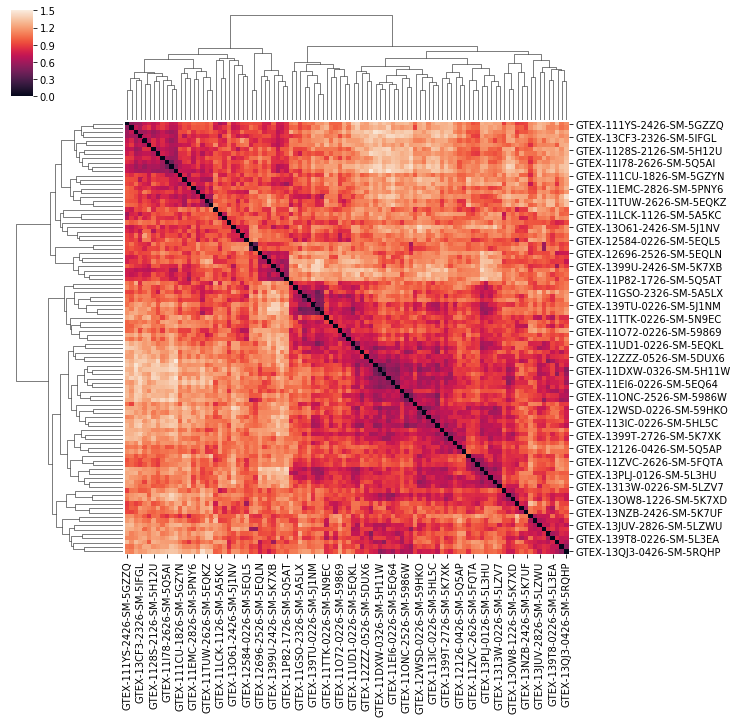

In [60]:
import scipy.spatial as sp, scipy.cluster.hierarchy as hc

dism = 1 - corrs_xr[:100, :100]   # distance matrix
linkage = hc.linkage(dism, method='average')
sel = pd.DataFrame(dism.values, columns=dism.observations_2.values, index=dism.observations_1.values)
sns.clustermap(sel, row_linkage=linkage, col_linkage=linkage)

In [95]:
sel[:10, :10]

<xarray.DataArray (observations_1: 10, observations_2: 10)>
array([[0.288952, 0.164215, 0.190773, 0.211516, 0.248392, 0.004276, 0.194031,
        0.13173 , 0.163973, 0.062864],
       [0.122164, 0.080822, 0.084113, 0.199823, 0.191536, 0.106861, 0.104504,
        0.134198, 0.119309, 0.082317],
       [0.053932, 0.088169, 0.068999, 0.060681, 0.042277, 0.135116, 0.011864,
        0.087305, 0.054512, 0.193013],
       [0.013799, 0.069731, 0.114289, 0.06839 , 0.104291, 0.137957, 0.080102,
        0.04367 , 0.064967, 0.103391],
       [0.097724, 0.067719, 0.145058, 0.135131, 0.131169, 0.019478, 0.15648 ,
        0.127364, 0.112959, 0.034252],
       [0.011064, 0.067024, 0.098058, 0.108222, 0.123514, 0.026946, 0.093144,
        0.130226, 0.124154, 0.077157],
       [0.069485, 0.126324, 0.068515, 0.023174, 0.037859, 0.024482, 0.04071 ,
        0.005516, 0.036124, 0.007794],
       [0.115217, 0.118333, 0.102023, 0.155949, 0.1077  , 0.08176 , 0.174423,
        0.157258, 0.10136 , 0.025019],
    

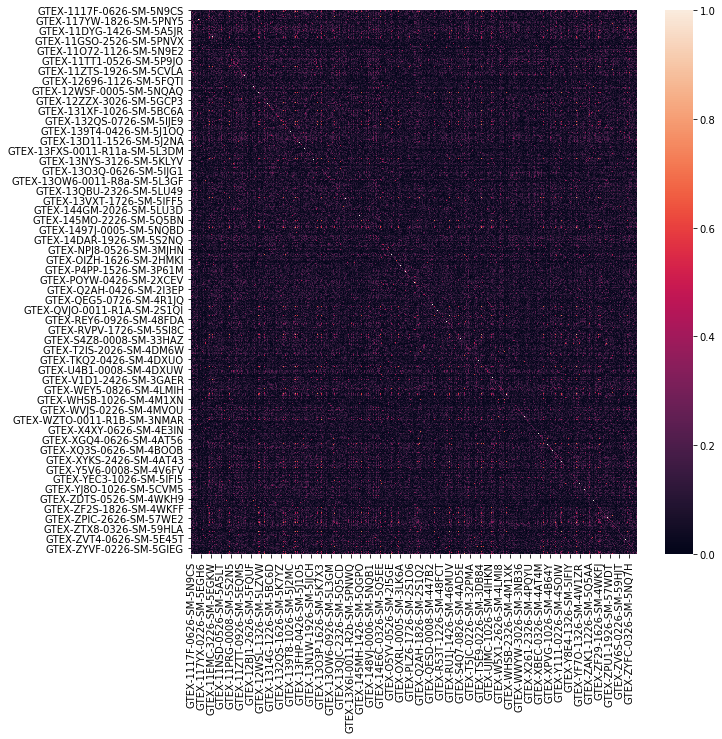

In [76]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(sel)

In [72]:
sel = np.abs(corrs_xr.sel(observations_1=(corrs_xr.subtissue_1 == "Whole Blood"), observations_2=(corrs_xr.subtissue_2 == "Lung")))
sel.sortby(["individual_1", "individual_2"])

<xarray.DataArray (observations_1: 365, observations_2: 297)>
array([[0.197116, 0.057138, 0.030326, ..., 0.097825, 0.158898, 0.020026],
       [0.06463 , 0.062884, 0.06543 , ..., 0.109743, 0.178099, 0.138577],
       [0.103648, 0.033883, 0.056031, ..., 0.102355, 0.097643, 0.237149],
       ...,
       [0.045269, 0.040995, 0.20611 , ..., 0.068999, 0.088169, 0.053932],
       [0.119414, 0.046776, 0.062431, ..., 0.084113, 0.080822, 0.122164],
       [0.141769, 0.051301, 0.097739, ..., 0.190773, 0.164215, 0.288952]])
Coordinates:
  * observations_1      (observations_1) object 'GTEX-ZXG5-0005-SM-57WCN' ... 'GTEX-111YS-0006-SM-5NQBE'
    RNA.Seq_1           (observations_1) object 'SRR1382485' ... 'SRR1397673'
    SRA_Sample_1        (observations_1) object 'SRS635146' ... 'SRS637707'
    sex_1               (observations_1) object 'male' 'female' ... 'male'
    BioSample_1         (observations_1) object 'SAMN02791282' ... 'SAMN02792951'
    Experiment_1        (observations_1) object 'SRX

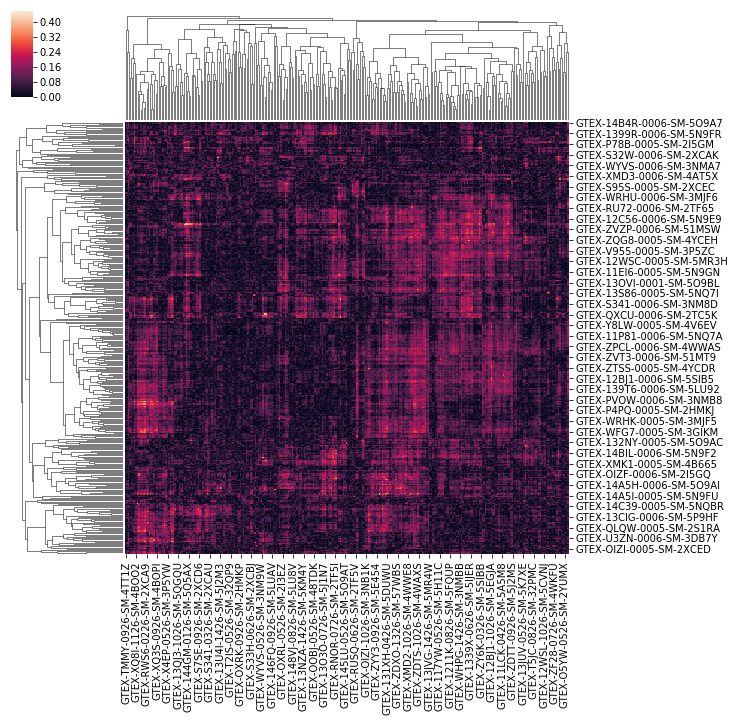

In [36]:
sel = np.abs(corrs_xr.sel(observations_1=(corrs_xr.subtissue_1 == "Whole Blood"), observations_2=(corrs_xr.subtissue_2 == "Lung")))
sel = pd.DataFrame(sel.values, columns=sel.observations_2.values, index=sel.observations_1.values)
sns.clustermap(sel, metric="correlation")

In [102]:
sel = corrs_xr.sel(observations_1=(corrs_xr.subtissue_1 == "Whole Blood"), observations_2=(corrs_xr.subtissue_2 == "Lung"))
sel

<xarray.DataArray (observations_1: 365, observations_2: 297)>
array([[ 0.288952, -0.164215, -0.190773, ..., -0.097739,  0.051301,  0.141769],
       [ 0.122164, -0.080822, -0.084113, ..., -0.062431,  0.046776,  0.119414],
       [-0.053932,  0.088169, -0.068999, ..., -0.20611 ,  0.040995, -0.045269],
       ...,
       [ 0.237149, -0.097643, -0.102355, ..., -0.056031,  0.033883,  0.103648],
       [-0.138577,  0.178099,  0.109743, ...,  0.06543 , -0.062884, -0.06463 ],
       [ 0.020026,  0.158898,  0.097825, ...,  0.030326,  0.057138, -0.197116]])
Coordinates:
  * observations_1      (observations_1) object 'GTEX-111YS-0006-SM-5NQBE' ... 'GTEX-ZXG5-0005-SM-57WCN'
    RNA.Seq_1           (observations_1) object 'SRR1397673' ... 'SRR1382485'
    SRA_Sample_1        (observations_1) object 'SRS637707' ... 'SRS635146'
    sex_1               (observations_1) object 'male' 'female' ... 'male'
    BioSample_1         (observations_1) object 'SAMN02792951' ... 'SAMN02791282'
    Experiment_1

In [106]:
amax_sel = np.abs(sel).argmax(dim="observations_2")
np.abs(sel).max(dim="observations_2")

<xarray.DataArray (observations_1: 365)>
array([0.321701, 0.21884 , 0.316697, ..., 0.247214, 0.269795, 0.252929])
Coordinates:
  * observations_1      (observations_1) object 'GTEX-111YS-0006-SM-5NQBE' ... 'GTEX-ZXG5-0005-SM-57WCN'
    RNA.Seq_1           (observations_1) object 'SRR1397673' ... 'SRR1382485'
    SRA_Sample_1        (observations_1) object 'SRS637707' ... 'SRS635146'
    sex_1               (observations_1) object 'male' 'female' ... 'male'
    BioSample_1         (observations_1) object 'SAMN02792951' ... 'SAMN02791282'
    Experiment_1        (observations_1) object 'SRX598823' ... 'SRX591953'
    tissue_1            (observations_1) object 'Blood' 'Blood' ... 'Blood'
    subtissue_1         (observations_1) object 'Whole Blood' ... 'Whole Blood'
    RIN_1               (observations_1) float64 8.2 7.6 8.6 7.6 ... 7.9 7.6 9.0
    SMAFRZE_1           (observations_1) object 'RNASEQ' 'RNASEQ' ... 'RNASEQ'
    WGS_1               (observations_1) float64 nan nan nan nan 

In [108]:
best_corr = pd.DataFrame({
    "obs_1" : sel.observations_1.values, 
    "obs_2": sel.observations_2[amax_sel].values, 
    "corr": sel.isel(observations_2 = amax_sel)
})
best_corr.head()

,obs_1,obs_2,corr
0,GTEX-111YS-0006-SM-5NQBE,GTEX-14DAR-0226-SM-5S2PR,0.321701
1,GTEX-1122O-0005-SM-5O99J,GTEX-12BJ1-1026-SM-5EGJA,0.218840
2,GTEX-113IC-0006-SM-5NQ9C,GTEX-S7SE-0926-SM-2XCD6,0.316697
3,GTEX-113JC-0006-SM-5O997,GTEX-11ZTS-1226-SM-5EQMQ,0.280996
4,GTEX-117YW-0005-SM-5NQ8Z,GTEX-R55C-0526-SM-3GIKA,-0.252916


In [113]:
best_corr_df = sel.isel(observations_2 = amax_sel).to_dataframe("corr")
best_corr_df.head()

,RNA.Seq_1,SRA_Sample_1,sex_1,BioSample_1,Experiment_1,tissue_1,subtissue_1,RIN_1,SMAFRZE_1,WGS_1,...,WXS_2,OUTRIDER_GROUP_2,COUNT_MODE_2,PAIRED_END_2,COUNT_OVERLAP_2,CHROMOSOME_STYLE_2,STRAND_2,sf_2,individual_2,corr
observations_1,,,,,,,,,,,,,,,,,,,,,
GTEX-111YS-0006-SM-5NQBE,SRR1397673,SRS637707,male,SAMN02792951,SRX598823,Blood,Whole Blood,8.2,RNASEQ,NaN,...,NaN,Lung,IntersectionStrict,True,True,NCBI,no,1.141867,GTEX-14DAR,0.321701
GTEX-1122O-0005-SM-5O99J,SRR1314916,SRS624986,female,SAMN02792945,SRX560883,Blood,Whole Blood,7.6,RNASEQ,NaN,...,NaN,Lung,IntersectionStrict,True,True,NCBI,no,1.232551,GTEX-12BJ1,0.218840
GTEX-113IC-0006-SM-5NQ9C,SRR1311644,SRS624013,male,SAMN02793445,SRX559021,Blood,Whole Blood,8.6,RNASEQ,NaN,...,NaN,Lung,IntersectionStrict,True,True,NCBI,no,0.696245,GTEX-S7SE,0.316697
GTEX-113JC-0006-SM-5O997,SRR1311062,SRS623982,female,SAMN02789261,SRX558754,Blood,Whole Blood,7.6,RNASEQ,NaN,...,NaN,Lung,IntersectionStrict,True,True,NCBI,no,0.844914,GTEX-11ZTS,0.280996
GTEX-117YW-0005-SM-5NQ8Z,SRR1368529,SRS631454,male,SAMN02792983,SRX584147,Blood,Whole Blood,8.5,RNASEQ,NaN,...,NaN,Lung,IntersectionStrict,True,True,NCBI,no,1.061910,GTEX-R55C,-0.252916


In [117]:
np.size(np.where(best_corr_df.individual_1 == best_corr_df.individual_2)) / best_corr_df.shape[0]

0.1506849315068493

In [134]:
best_corr_df[best_corr_df.individual_1 == best_corr_df.individual_2][["observations_2", "corr"]].head()

,observations_2,corr
observations_1,,
GTEX-11GSP-0006-SM-5N9EL,GTEX-11GSP-0726-SM-5986L,0.292905
GTEX-11TUW-0006-SM-5LZW2,GTEX-11TUW-0526-SM-5LU9A,0.247184
GTEX-1269C-0005-SM-5N9CJ,GTEX-1269C-0926-SM-5FQSR,0.280102
GTEX-12BJ1-0006-SM-5SIB5,GTEX-12BJ1-1026-SM-5EGJA,0.318378
GTEX-131XH-0006-SM-5O98V,GTEX-131XH-0426-SM-5DUWU,0.236532


In [141]:
best_corr_df.loc[best_corr_df["corr"].idxmax()]

RNA.Seq_1                           SRR613963
SRA_Sample_1                        SRS374878
sex_1                                    male
BioSample_1                      SAMN01772478
Experiment_1                        SRX203829
tissue_1                                Blood
subtissue_1                       Whole Blood
RIN_1                                     9.4
SMAFRZE_1                              RNASEQ
WGS_1                                     NaN
WXS_1                                     NaN
OUTRIDER_GROUP_1                  Whole_Blood
COUNT_MODE_1               IntersectionStrict
PAIRED_END_1                             True
COUNT_OVERLAP_1                          True
CHROMOSOME_STYLE_1                       NCBI
STRAND_1                                   no
sf_1                                   1.3766
individual_1                        GTEX-QXCU
observations_2        GTEX-QXCU-0626-SM-2TC69
RNA.Seq_2                           SRR615129
SRA_Sample_2                      

In [142]:
x = xrds.sel(observations="GTEX-QXCU-0006-SM-2TC5K")
y = xrds.sel(observations="GTEX-QXCU-0626-SM-2TC69")


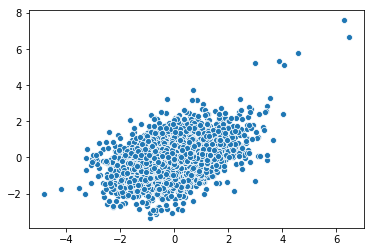

In [143]:
sns.scatterplot(x, y)

In [19]:
tissue = blood
other_tissue = lung

tissue_df = pd.DataFrame(tissue.values, columns=tissue.features, index=tissue.observations)
other_tissue_df = pd.DataFrame(other_tissue.values, columns=other_tissue.features, index=other_tissue.observations)


In [23]:
tissue_df.T.corr()

observations,GTEX-111YS-0006-SM-5NQBE,GTEX-1122O-0005-SM-5O99J,GTEX-113IC-0006-SM-5NQ9C,GTEX-113JC-0006-SM-5O997,GTEX-117YW-0005-SM-5NQ8Z,GTEX-1192W-0005-SM-5NQBQ,GTEX-1192X-0005-SM-5NQC3,GTEX-11DXW-0006-SM-5NQ7Y,GTEX-11DXX-0005-SM-5NQ8B,GTEX-11DXY-0006-SM-5NQ8N,...,GTEX-ZUA1-0005-SM-4YCEV,GTEX-ZV68-0006-SM-4YCEJ,GTEX-ZV7C-0005-SM-57WDL,GTEX-ZVE2-0006-SM-51MRW,GTEX-ZVT2-0005-SM-57WBW,GTEX-ZVT3-0006-SM-51MT9,GTEX-ZVT4-0006-SM-57WB8,GTEX-ZVZP-0006-SM-51MSW,GTEX-ZVZQ-0006-SM-51MR8,GTEX-ZXG5-0005-SM-57WCN
observations,,,,,,,,,,,,,,,,,,,,,
GTEX-111YS-0006-SM-5NQBE,1.000000,0.997549,0.996510,-0.996208,-0.250057,-0.788917,-0.979496,0.995768,0.998193,0.507571,...,0.877945,0.996486,0.997558,-0.946394,0.994376,-0.911995,0.993767,0.998994,-0.174626,0.996966
GTEX-1122O-0005-SM-5O99J,0.997549,1.000000,0.998850,-0.991120,-0.198918,-0.756657,-0.989199,0.998670,0.993694,0.556735,...,0.855720,0.995318,0.999836,-0.962796,0.996341,-0.888995,0.997304,0.998935,-0.119488,0.999205
GTEX-113IC-0006-SM-5NQ9C,0.996510,0.998850,1.000000,-0.991401,-0.201192,-0.758150,-0.988201,0.999342,0.992089,0.558988,...,0.862021,0.996720,0.998646,-0.960648,0.994275,-0.886801,0.996352,0.997232,-0.116170,0.999519
GTEX-113JC-0006-SM-5O997,-0.996208,-0.991120,-0.991401,1.000000,0.319444,0.832422,0.963064,-0.990082,-0.998175,-0.449934,...,-0.912755,-0.997614,-0.990674,0.921653,-0.988131,0.936902,-0.986593,-0.993075,0.235267,-0.992007
GTEX-117YW-0005-SM-5NQ8Z,-0.250057,-0.198918,-0.201192,0.319444,1.000000,0.789098,0.056925,-0.190686,-0.297514,0.674204,...,-0.648148,-0.274305,-0.194721,-0.054685,-0.221481,0.617737,-0.177627,-0.216567,0.951077,-0.204639
GTEX-1192W-0005-SM-5NQBQ,-0.788917,-0.756657,-0.758150,0.832422,0.789098,1.000000,0.656029,-0.751576,-0.818565,0.098455,...,-0.968453,-0.805465,-0.753738,0.565870,-0.768706,0.965259,-0.741901,-0.767830,0.697853,-0.760673
GTEX-1192X-0005-SM-5NQC3,-0.979496,-0.989199,-0.988201,0.963064,0.056925,0.656029,1.000000,-0.989704,-0.968838,-0.667660,...,-0.776146,-0.974053,-0.989682,0.990738,-0.982363,0.814773,-0.990582,-0.985982,-0.022290,-0.988002
GTEX-11DXW-0006-SM-5NQ7Y,0.995768,0.998670,0.999342,-0.990082,-0.190686,-0.751576,-0.989704,1.000000,0.991047,0.567665,...,0.857503,0.995867,0.998572,-0.963422,0.992964,-0.882390,0.998006,0.997185,-0.103032,0.999612
GTEX-11DXX-0005-SM-5NQ8B,0.998193,0.993694,0.992089,-0.998175,-0.297514,-0.818565,-0.968838,0.991047,1.000000,0.466096,...,0.896313,0.995966,0.993495,-0.931682,0.992525,-0.931145,0.989144,0.996232,-0.218683,0.993050


In [ ]:
corrs = np.corrcoef([xrds.where(xrds.subtissue=="Whole Blood"), xrds.where(xrds.subtissue=="Adipose - Subcutaneous"))

In [11]:
np.corrcoef([xrds[1:3].values, xrds[1:3].values])

ValueError: m has more than 2 dimensions

In [103]:
corrs.individual_1 == corrs.individual_2

<xarray.DataArray (observations_1: 6766, observations_2: 6766)>
array([[ True, False, False, ..., False, False, False],
       [False,  True, False, ..., False, False, False],
       [False, False,  True, ..., False, False, False],
       ...,
       [False, False, False, ...,  True, False, False],
       [False, False, False, ..., False,  True, False],
       [False, False, False, ..., False, False,  True]])
Coordinates:
  * observations_1      (observations_1) object 'GTEX-111CU-1826-SM-5GZYN' ... 'GTEX-ZXG5-0005-SM-57WCN'
    RNA.Seq_1           (observations_1) object 'SRR1310275' ... 'SRR1382485'
    SRA_Sample_1        (observations_1) object 'SRS623944' ... 'SRS635146'
    sex_1               (observations_1) object 'male' 'male' ... 'male'
    BioSample_1         (observations_1) object 'SAMN02789465' ... 'SAMN02791282'
    Experiment_1        (observations_1) object 'SRX558418' ... 'SRX591953'
    tissue_1            (observations_1) object 'Adipose Tissue' ... 'Blood'
    sub

In [59]:
def generate_toy_data():
    genes = list(map(lambda x: "Gene_" + str(x) , list(range(1, 1001))))
    distribution_tissues = nr.uniform(1,len(tissues),1000)
    
    # generate samples - raw counts per gene per tissue
    frames = []
    for i in range(1,150): # patients

        # choose tissues
        how_many_tissues = math.floor(distribution_tissues[random.randint(0,len(distribution_tissues))-1])
        random.shuffle(tissues)
        t_set = tissues[:how_many_tissues]  

        # initialize count matrix
        counts = pd.DataFrame(columns=genes,index=map(lambda x: "Patient_" + str(i) + "_" + str(x), t_set))

        for j in range(0,len(t_set)):

            col_name = "Patient_" + str(i) + "_" + t_set[j]

            # generate raw counts per tissue per set of genes
            raw_counts = np.random.negative_binomial(15,0.001,1000)
            counts.loc[col_name] = raw_counts.reshape(1,1000)

        # append expression per tissue for the patient 
        frames.append(counts)


    df_big = pd.concat(frames)
    
    # transpose the matrix to be genes x patient_tissue
    count_matrix = df_big.transpose()
    
    # create annotation dataframes
    # column = 0 its the index! be careful
    samples_anno = pd.DataFrame(index=count_matrix.columns,columns=['Individual','Tissue'])
    gender=[1,2]
    seq=['WGS','WXS']

    for i in range(0,samples_anno.shape[0]):
        sample = samples_anno.index[i]
        [pat,number,tissue] = sample.split("_")

        samples_anno.at[sample, 'Individual'] = pat + "_" + str(number)
        samples_anno.at[sample, 'Tissue'] = tissue
        samples_anno.at[sample, 'Gender'] = gender[int(number)%2]
        samples_anno.at[sample, 'Seq'] = seq[int(number)%2]

    samples_anno.drop_duplicates().shape
    
    genes_anno = pd.DataFrame(index=count_matrix.index)
    
    annobj = anndata.AnnData(count_matrix)
    annobj.var = samples_anno
    annobj.var_names = list(samples_anno.index)
    annobj.obs = genes_anno
    annobj.obs_names = list(genes_anno.index)
    
    return annobj

In [60]:
sample = generate_toy_data()

In [64]:
def compute_baseline(annobj):
    tissues = annobj.var['Tissue'].drop_duplicates().tolist()
    Y_mean_tissue = np.zeros((len(annobj.obs_names),len(tissues)))
    
    for t in tissues:
        slice_bytissue = annobj[:,annobj.var['Tissue'] == t]    
        mean_value = np.log2(np.mean(np.square(slice_bytissue.X),axis=1)+1)
        Y_mean_tissue[:,tissues.index(t)] = mean_value

    
    return pd.DataFrame(data = Y_mean_tissue, index = annobj.obs_names, columns = tissues) 


In [65]:
baseline = compute_baseline(sample)

In [66]:
baseline

,Artery - Coronary,Esophagus - Mucosa,Heart - Left Ventricle,Pituitary,Fallopian Tube,Brain - Spinal cord (cervical c-1),Brain - Cerebellar Hemisphere,Brain - Anterior cingulate cortex (BA24),Brain - Hypothalamus,Brain - Substantia nigra,...,Brain - Cortex,Brain - Caudate (basal ganglia),Muscle - Skeletal,Pancreas,Adipose - Subcutaneous,Cervix - Endocervix,Nerve - Tibial,Colon - Transverse,Breast - Mammary Tissue,Heart - Atrial Appendage
Gene_1,27.885340,27.922901,27.977518,27.919188,27.562105,27.931711,27.795280,27.905949,27.893270,27.834501,...,27.879698,27.900808,27.919313,27.892853,27.859648,27.788429,28.033630,28.051970,27.992004,27.694468
Gene_2,28.039248,27.647516,27.885303,27.876909,27.882719,27.706114,27.644224,27.880739,27.815697,27.735956,...,27.635820,27.887617,27.798553,27.770082,27.789265,27.885025,27.751713,27.879604,27.791679,27.700954
Gene_3,27.869024,27.861450,27.991861,27.891439,27.909492,27.847511,27.914717,27.786364,27.931067,27.837469,...,27.943384,27.883493,27.791605,27.656429,27.906956,27.821249,27.901936,27.822067,27.741999,27.904125
Gene_4,27.804726,27.868799,27.760477,27.648029,27.797638,27.866293,27.934340,27.972626,27.927206,27.825323,...,27.791304,27.847092,27.771002,27.897951,27.842571,27.793806,27.705992,28.028816,27.777672,27.790958
Gene_5,27.747849,27.839577,27.744429,27.922188,27.771614,27.768324,27.785646,27.739744,27.751833,27.619955,...,27.923103,27.737688,27.893349,27.897516,27.901423,27.807087,27.768612,27.900570,27.813147,27.661951
Gene_6,27.975245,27.731451,27.892572,27.801586,27.984909,27.714195,27.707422,27.852083,27.796160,27.854063,...,27.823328,27.848553,27.881411,27.867968,27.742680,27.797123,27.900436,27.766935,27.862934,27.714745
Gene_7,27.901598,27.844767,27.867695,27.621351,27.927431,27.831234,27.874454,27.709286,27.781141,27.802881,...,27.845364,27.861574,27.727398,27.732935,27.814796,27.812250,27.828508,27.796865,27.758627,27.813087
Gene_8,27.833202,27.862181,27.945583,27.648767,27.707901,27.866886,27.822901,27.831944,27.921007,27.732462,...,27.830971,27.684137,27.886314,27.952908,27.832108,27.995878,27.879393,27.842024,27.796255,27.826681
Gene_9,27.787390,27.738886,27.776646,27.793470,27.872534,27.866169,27.685286,27.945158,27.822926,27.888788,...,27.825451,27.760363,27.853895,27.918171,27.857645,27.815689,27.798910,27.777559,27.835468,27.877628
Gene_10,27.867830,27.859241,27.808033,27.920609,27.880476,27.859007,27.775599,28.004229,27.735786,27.843870,...,27.789158,27.929661,27.873974,27.784660,27.924004,27.766634,27.820904,27.934959,27.962709,27.810963


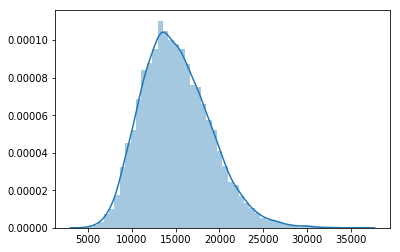

In [56]:
x = np.random.negative_binomial(15,0.001,10000)
sns.distplot(x)

In [70]:
slice_bytissue = np.arange(10,3)
slice_bytissue

array([], dtype=int64)

In [72]:
np.log2(np.mean(np.square(slice_bytissue),axis=1)+1)

IndexError: tuple index out of range

In [73]:
import joblib

In [75]:
from sklearn.pipeline import Pipeline

In [77]:
import pickle
?pickle.dumps

Signature: pickle.dumps(obj, protocol=None, *, fix_imports=True)
Docstring:
Return the pickled representation of the object as a bytes object.

The optional *protocol* argument tells the pickler to use the given
protocol; supported protocols are 0, 1, 2, 3 and 4.  The default
protocol is 3; a backward-incompatible protocol designed for Python 3.

Specifying a negative protocol version selects the highest protocol
version supported.  The higher the protocol used, the more recent the
version of Python needed to read the pickle produced.

If *fix_imports* is True and *protocol* is less than 3, pickle will
try to map the new Python 3 names to the old module names used in
Python 2, so that the pickle data stream is readable with Python 2.
Type:      builtin_function_or_method


In [84]:
# load gtex summarized experiment
import rep.preprocessing as p
import os
path = os.path.join(os.readlink(os.path.join("..","..","data")),"processed","gtex","input_data")

In [88]:
x_train = p.readh5(os.path.join(path,'X_train_pc.h5'))

In [90]:
y_train =  p.readh5(os.path.join(path,'Y_train_pc.h5'))

In [97]:
p.writeh5(x_train[:1000,:100],"xtrain","xtrain_mock.h5")

In [98]:
p.writeh5(y_train[:1000,:100],"ytrain","ytrain_mock.h5")

In [99]:
p.writeh5(x_train[1000:2000,:100],"xvalid","xvalid_mock.h5")
p.writeh5(y_train[1000:2000,:100],"yvalid","yvalid_mock.h5")

In [100]:
os.getcwd()

'/data/nasif12/home_if12/giurgiu/rep_gagneur/rep/notebooks/tutorials'

In [101]:
x_train[1000:2000,:100]

array([[5.5899897, 3.195069 , 5.218777 , ..., 4.6731405, 3.935608 ,
        5.650378 ],
       [5.5899897, 3.195069 , 5.218777 , ..., 4.6731405, 3.935608 ,
        5.650378 ],
       [5.5899897, 3.195069 , 5.218777 , ..., 4.6731405, 3.935608 ,
        5.650378 ],
       ...,
       [4.8776016, 3.2605484, 4.9322047, ..., 4.795595 , 3.8667006,
        5.5314136],
       [4.8776016, 3.2605484, 4.9322047, ..., 4.795595 , 3.8667006,
        5.5314136],
       [4.8776016, 3.2605484, 4.9322047, ..., 4.795595 , 3.8667006,
        5.5314136]], dtype=float32)

In [1]:
from sklearn.decomposition import PCA

In [14]:
from sklearn.linear_model import LarsCV

In [15]:
??LarsCV

Init signature:
LarsCV(
    ['fit_intercept=True', 'verbose=False', 'max_iter=500', 'normalize=True', "precompute='auto'", "cv='warn'", 'max_n_alphas=1000', 'n_jobs=None', 'eps=2.220446049250313e-16', 'copy_X=True', 'positive=False'],
)
Source:        
class LarsCV(Lars):
    """Cross-validated Least Angle Regression model

    Read more in the :ref:`User Guide <least_angle_regression>`.

    Parameters
    ----------
    fit_intercept : boolean
        whether to calculate the intercept for this model. If set
        to false, no intercept will be used in calculations
        (e.g. data is expected to be already centered).

    verbose : boolean or integer, optional
        Sets the verbosity amount

    max_iter : integer, optional
        Maximum number of iterations to perform.

    normalize : boolean, optional, default True
        This parameter is ignored when ``fit_intercept`` is set to False.
        If True, the regressors X will be normalized before regression by
        su

In [18]:
from torch.optim import SGD

In [19]:
??SGD

Init signature:
SGD(
    ['params', 'lr=<object object at 0x7f2e8cc31ad0>', 'momentum=0', 'dampening=0', 'weight_decay=0', 'nesterov=False'],
)
Source:        
class SGD(Optimizer):
    r"""Implements stochastic gradient descent (optionally with momentum).

    Nesterov momentum is based on the formula from
    `On the importance of initialization and momentum in deep learning`__.

    Args:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float): learning rate
        momentum (float, optional): momentum factor (default: 0)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
        dampening (float, optional): dampening for momentum (default: 0)
        nesterov (bool, optional): enables Nesterov momentum (default: False)

    Example:
        >>> optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
        >>> optimizer.zero_grad()
        >>> loss_fn(model(input), tar

In [20]:
from torch.utils.data import DataLoader

In [21]:
??DataLoader

Init signature:
DataLoader(
    ['dataset', 'batch_size=1', 'shuffle=False', 'sampler=None', 'batch_sampler=None', 'num_workers=0', 'collate_fn=<function default_collate at 0x7f2e47f8e7b8>', 'pin_memory=False', 'drop_last=False', 'timeout=0', 'worker_init_fn=None'],
)
Source:        
class DataLoader(object):
    r"""
    Data loader. Combines a dataset and a sampler, and provides
    single- or multi-process iterators over the dataset.

    Arguments:
        dataset (Dataset): dataset from which to load the data.
        batch_size (int, optional): how many samples per batch to load
            (default: 1).
        shuffle (bool, optional): set to ``True`` to have the data reshuffled
            at every epoch (default: False).
        sampler (Sampler, optional): defines the strategy to draw samples from
            the dataset. If specified, ``shuffle`` must be False.
        batch_sampler (Sampler, optional): like sampler, but returns a batch of
            indices at a time. Mut

In [22]:
import torch
import torch.nn as nn

In [24]:
from scipy.stats.mstats import gmean
import numpy as np

In [61]:
x1 = np.arange(3.0)
x2 = np.arange(3.0)

In [62]:
x1

array([0., 1., 2.])

In [63]:
x2

array([0., 1., 2.])

In [64]:
mean = np.mean(np.array([x1,x2]), axis=0)

In [65]:
geo = gmean(np.array([x1,x2]), axis=0)

In [66]:
mean

array([0., 1., 2.])

In [67]:
geo

array([0., 1., 2.])

In [68]:
np.mean(np.divide(geo,mean))

/opt/modules/i12g/anaconda/3-5.0.1/envs/rep/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


nan